In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from mrmr_wrapper import MRMRTransformer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            roc_curve, precision_recall_curve, 
                            average_precision_score)

# Import Data

In [ ]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

print("Number of Comfort Score == 3:", (labels_shuffled == 3).sum())

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] # The "~" operator is used to filter out NaN values (i.e., rows where Comfort Score == 3)

# Train/Test Split

In [ ]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# Run optimization for feature selection and Catboost classification parameters for a variable number of trials

In [ ]:
# Define trial numbers
trial_numbers = [5, 10, 25, 50, 100, 200, 250, 300, 400, 500]

# Store results
results = {
    'n_trials': [],
    'best_roc_auc_cv': [],  # Cross-validation ROC-AUC
    'test_roc_auc': [],     # Test set ROC-AUC
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'best_params': []
}

X = X_train.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step=10)
        if fs_method == 'RFE':
            estimator = RandomForestClassifier(random_state=42)
            selector = RFE(estimator, n_features_to_select=k_features)
        else: # MRMR
            selector = MRMRTransformer(k_features=k_features)
    else:
        selector = 'passthrough'
    
    # CatBoost hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=25),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), 
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False,
    }

    model = CatBoostClassifier(**params)

    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

def evaluate_on_test_set(best_params, X_train, y_train, X_test, y_test):
    """
    Evaluate the best model from optimization on test set
    """
    # Apply feature selection to training data
    best_fs_method = best_params.get('feature_selection', 'None')
    
    if best_fs_method != 'None':
        k_features = best_params['k_features']
        if best_fs_method == 'RFE':
            estimator = RandomForestClassifier(random_state=42)
            selector = RFE(estimator, n_features_to_select=k_features)
        elif best_fs_method == 'MRMR':
            selector = MRMRTransformer(k_features=k_features)
        
        selector.fit(X_train, y_train)
        if hasattr(selector, 'get_support'):  # For RFE
            selected_features = X_train.columns[selector.get_support()]
        else:  # For MRMRTransformer
            selected_features = selector.selected_features
        X_train_best = X_train[selected_features]
    else:
        X_train_best = X_train
        selected_features = X_train.columns

    # Apply the same feature selection to test data
    if best_fs_method != 'None':
        if best_fs_method == 'MRMR':
            X_test_best = X_test[selected_features]
        else:
            X_test_best = selector.transform(X_test)
            if isinstance(X_test, pd.DataFrame):
                X_test_best = pd.DataFrame(X_test_best, columns=selected_features, index=X_test.index)
    else:
        X_test_best = X_test

    # Create and train final model
    final_model = CatBoostClassifier(
        iterations=best_params['iterations'],
        depth=best_params['depth'],
        learning_rate=best_params['learning_rate'],
        l2_leaf_reg=best_params['l2_leaf_reg'],
        random_strength=best_params['random_strength'],
        bagging_temperature=best_params['bagging_temperature'],
        border_count=best_params['border_count'],
        random_seed=42,
        verbose=False
    )

    # Train on full training data
    final_model.fit(X_train_best, y_train)

    # Make predictions on test set
    y_pred = final_model.predict(X_test_best)
    y_pred_proba = final_model.predict_proba(X_test_best)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'selected_features': selected_features if best_fs_method != 'None' else 'All features'
    }

# Run optimization for each number of trials
for n_trials in trial_numbers:
    print(f"\n{'='*60}")
    print(f"Running {n_trials} trials and evaluating on test set...")
    print(f"{'='*60}")
    
    # Create study with TPESampler
    study = optuna.create_study(direction='maximize')
    
    # Run optimization
    study.optimize(
        binary_classification_objective, 
        n_trials=n_trials, 
        show_progress_bar=True
    )
    
    # Evaluate on test set
    test_results = evaluate_on_test_set(
        study.best_params, 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    
    # Store results
    results['n_trials'].append(n_trials)
    results['best_roc_auc_cv'].append(study.best_value) # Cross-validation ROC-AUC on training set
    results['test_roc_auc'].append(test_results['roc_auc'])
    results['test_accuracy'].append(test_results['accuracy'])
    results['test_precision'].append(test_results['precision'])
    results['test_recall'].append(test_results['recall'])
    results['test_f1'].append(test_results['f1'])
    results['best_params'].append(study.best_params)
    
    print(f"CV ROC-AUC after {n_trials} trials: {study.best_value:.4f}")
    print(f"Test ROC-AUC after {n_trials} trials: {test_results['roc_auc']:.4f}")
    print(f"Feature selection: {test_results['selected_features']}")

# Plot the ROC-AUC curves
plt.figure(figsize=(14, 10))

# Subplot 1: ROC-AUC comparison
plt.subplot(2, 1, 1)
plt.plot(results['n_trials'], results['best_roc_auc_cv'], 'bo-', linewidth=2, markersize=8, label='Train ROC AUC')
plt.plot(results['n_trials'], results['test_roc_auc'], 'ro-', linewidth=2, markersize=8, label='Test ROC AUC')
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('ROC AUC Score [Train & Test]', fontsize=12)
plt.title('Optimization Progress: ROC AUC vs Number of Trials', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(results['n_trials'])
plt.ylim(0, 1)
plt.legend()

# Add value annotations
for i, (n, cv_score, test_score) in enumerate(zip(results['n_trials'], results['best_roc_auc_cv'], results['test_roc_auc'])):
    plt.annotate(f'Train: {cv_score:.3f}\nTest: {test_score:.3f}', 
                (n, max(cv_score, test_score)), 
                textcoords="offset points", 
                xytext=(0,15), ha='center', fontsize=8)

# Subplot 2: Other metrics
plt.subplot(2, 1, 2)
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['green', 'orange', 'purple', 'brown']

for metric, label, color in zip(metrics, labels, colors):
    plt.plot(results['n_trials'], results[metric], 'o-', linewidth=2, markersize=6, label=label, color=color)

plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Test Set Metrics vs Number of Trials', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(results['n_trials'])
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("\n" + "="*80)
print("FINAL OPTIMIZATION AND TEST SET RESULTS SUMMARY")
print("="*80)
print(f"{'Trials':>8} {'Train ROC AUC':>10} {'Test ROC AUC':>12} {'Accuracy':>10} {'Precision':>10} {'Recall':>8} {'F1':>8}")
print("-" * 80)

for i, n_trials in enumerate(results['n_trials']):
    print(f"{n_trials:8d} {results['best_roc_auc_cv'][i]:10.4f} {results['test_roc_auc'][i]:12.4f} "
          f"{results['test_accuracy'][i]:10.4f} {results['test_precision'][i]:10.4f} "
          f"{results['test_recall'][i]:8.4f} {results['test_f1'][i]:8.4f}")

# Show best overall result
best_overall_idx = np.argmax(results['test_roc_auc'])
print(f"\nBest overall test result:")
print(f"Trials: {results['n_trials'][best_overall_idx]} | Test ROC AUC: {results['test_roc_auc'][best_overall_idx]:.4f}")
print("Best parameters:")
for key, value in results['best_params'][best_overall_idx].items():
    print(f"  {key}: {value}")

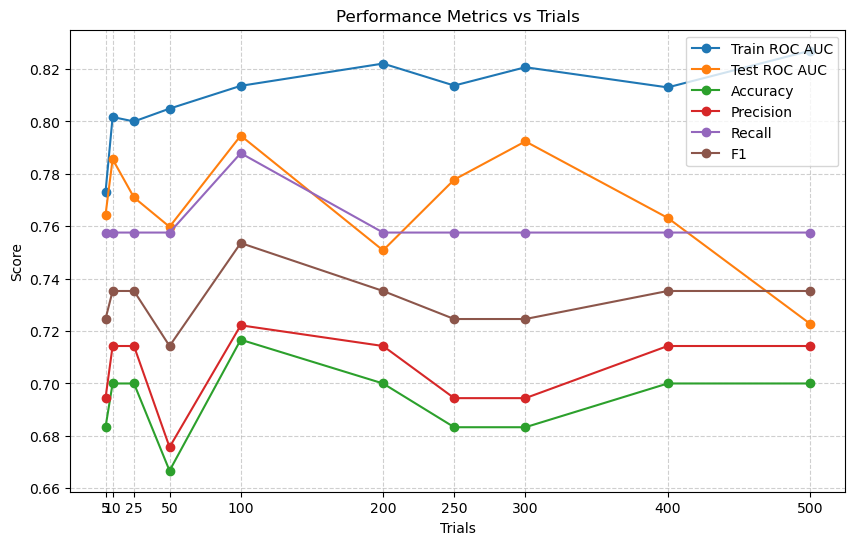

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from your results
data = {
    "Trials":   [5, 10, 25, 50, 100, 200, 250, 300, 400, 500],
    "Train ROC AUC": [0.7730, 0.8017, 0.8000, 0.8049, 0.8136, 0.8221, 0.8137, 0.8207, 0.8130, 0.8270],
    "Test ROC AUC":  [0.7643, 0.7856, 0.7710, 0.7598, 0.7946, 0.7508, 0.7778, 0.7924, 0.7632, 0.7228],
    "Accuracy":      [0.6833, 0.7000, 0.7000, 0.6667, 0.7167, 0.7000, 0.6833, 0.6833, 0.7000, 0.7000],
    "Precision":     [0.6944, 0.7143, 0.7143, 0.6757, 0.7222, 0.7143, 0.6944, 0.6944, 0.7143, 0.7143],
    "Recall":        [0.7576, 0.7576, 0.7576, 0.7576, 0.7879, 0.7576, 0.7576, 0.7576, 0.7576, 0.7576],
    "F1":            [0.7246, 0.7353, 0.7353, 0.7143, 0.7536, 0.7353, 0.7246, 0.7246, 0.7353, 0.7353],
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot all metrics except Trials
plt.figure(figsize=(10,6))
for column in df.columns[1:]:  # skip 'Trials'
    plt.plot(df["Trials"], df[column], marker='o', label=column)

plt.title("Performance Metrics vs Trials")
plt.xlabel("Trials")
plt.xticks(df["Trials"])   
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
